In [5]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [6]:
import json
from glob import glob
from pathlib import Path
from typing import NewType, Iterable, Callable

import nvector
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import nvector as nv

# ml
import tensorflow
from sklearn.manifold import LocallyLinearEmbedding

# plotting
import matplotlib.pyplot as plt

# number of seconds in 2 mins
TWO_MINS = 120.0
idx: slice = pd.IndexSlice

FeatureCollection = NewType("FeatureCollection", dict)

wgs84 = nv.FrameE(name="WGS84")

all_files = sorted(glob("/workspaces/sppp/data/probsevere/2021/**/*.json"))

['/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_120000.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_120200.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_120400.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_120600.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_120800.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_121000.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_121200.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_121400.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_121600.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_121800.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_122000.json',
 '/workspaces/sppp/data/probsevere/2021/10/MRMS_PROBSEVERE_20211010_122200.json',
 '/workspaces/sp

In [7]:
# data transformation and initial loading
def open_file(filepath: Path) -> FeatureCollection:
    with filepath.open("rb") as fin:
        return json.load(fin)


def to_dataframe(fc: FeatureCollection) -> pd.DataFrame:
    df = gpd.GeoDataFrame.from_features(fc["features"])
    df["validTime"] = pd.to_datetime(fc["validTime"], format="%Y%m%d_%H%M%S %Z")
    df["CENTROID"] = df["geometry"].centroid

    def ecef_vector():
        for point in df["geometry"].centroid:
            geo_point = wgs84.GeoPoint(
                longitude=point.x, latitude=point.y, degrees=True
            )
            yield geo_point.to_ecef_vector()

    df["ECEF_VECTOR"] = tuple(ecef_vector())

    df = df.set_index(["validTime", "ID"])
    return df
    # df =


def to_midf() -> pd.DataFrame:
    def generate():
        for file in all_files:
            fc = open_file(Path(file))
            yield to_dataframe(fc)

    return pd.concat(generate())


midf = to_midf()
midf

In [ ]:
# helper function
from sklearn.manifold import LocallyLinearEmbedding
from sppp.transfer.const import GridSpace


grid = GridSpace()


def embed(df: pd.DataFrame, grid: GridSpace) -> pd.DataFrame:

    lle = LocallyLinearEmbedding(n_components=1, n_neighbors=10)
    fresh = df[["PS", "MOTION_EAST", "MOTION_SOUTH"]].copy()
    cent = df["geometry"].centroid
    fresh["STAB"] = lle.fit_transform(midf[["MUCAPE", "MLCAPE", "MLCIN"]])
    fresh = fresh.astype(np.float32)

    fresh["X"] = np.argmin(abs(cent.x.values[:, np.newaxis] - grid.x), axis=1)
    fresh["Y"] = np.argmin(abs(cent.y.values[:, np.newaxis] - grid.y), axis=1)

    return fresh


zeros = grid.zeros_grid()


fresh = midf.pipe(embed, grid).loc[idx[:, "89519"], :]

In [ ]:
# machine learning support classes
import keras

# from tensorflow import keras
from keras.engine.sequential import Sequential

# keras:K


class State:
    __has_state: bool = False

    def __init__(self):
        self.__latests: pd.DataFrame = None
        self.__state: pd.DataFrame = None

    def __repr__(self) -> str:
        return self.__state.__repr__()

    @property
    def latests(self) -> pd.DataFrame:
        return self.__latests

    def set_storm(self, df: pd.DataFrame) -> None:

        self.__latests = df

        if not self.__has_state:
            self.__has_state = True
            self.__state = df
        else:
            old = self.__state
            self.__state = pd.concat([old, df])

    def iterstorms(self):
        df = self.__state.iloc[-2:].groupby("ID")
        for id, x in self.__state.iloc[-2:].groupby("ID"):
            yield x

    def has_hist(self) -> bool:
        return isinstance(self.__state, pd.DataFrame)

    @property
    def frame(self) -> pd.DataFrame:
        return self.__state


def build_model(frame_b: pd.DataFrame) -> Sequential:
    model = keras.models.Sequential(
        [
            keras.layers.Dense(
                22.5,
                activation="elu",
                input_shape=frame_b.shape,
            ),
            keras.layers.Dense(
                22.5,
                activation="sigmoid",
            ),
            keras.layers.Dense(3),
        ]
    )
    return model


def make_reward_map() -> np.ndarray:
    """creates 11x11 matrix"""
    a = list(np.linspace(0, 0.25, 5))
    a2 = np.array(a + [0.5] + list(reversed(a)))
    return a2 + a2[:, np.newaxis]

In [ ]:
import tensorflow as tf
import gym

from sppp.transfer.funcs import mask_frames_by_id
from sppp.transfer.const import GridSpace

grid = GridSpace()


class SPPPEnv(gym.Env):
    def __init__(self, state: "State") -> None:
        self.state = state

    def _compute_reward(self) -> int:
        return 1

    def step(self, action: np.ndarray):
        # action is produced by DQN, action is discrete
        # self.cache.move(action)
        # compute reward based on state(position) of the car
        # storm_state = self.car_agent.getCarState()
        # reward = self._compute_reward(storm_state)
        # # check if the episode is done
        # car_controls = self.car_agent.getCarControls()
        # done = self._isDone(storm_state, car_controls, reward)
        # # log info
        # info = {}
        # # observation is RGB image from car's camera
        # observation = self.car_agent.observe()
        observation = self.state.latests
        reward = self._compute_reward()
        done = False
        info = {}
        return observation, reward, done, info

    @property
    def observation_space(self) -> pd.DataFrame:
        return self.state.latests


def iterframe(df: pd.DataFrame) -> Iterable[tuple[pd.Timestamp, pd.DataFrame]]:
    yield from df.groupby("validTime")


n_inputs = 4
state = State()
env = SPPPEnv(state)
loss = keras.losses.binary_crossentropy
reward_map = make_reward_map()


n_outputs = 5
box_shape = 5


def reward_matrix(x: int, y: int, box_size: int = 5):
    gamefield = (
        zeros.loc[
            y - box_size : y + box_size,
            x - box_size : x + box_size,
        ].copy()
        + reward_map
    )
    return gamefield.values


transition_probs = [[0, 0, 1] * 20] * 101
possible_actions = [[0, 1, 2], [0, 2], [1]] * 101  # [list(range(-5, 5))] * 101


def swp_class_ploicy(
    state: int,  # probiblity of severe weather
    epsilon=0,
):
    if np.random.rand() < epsilon:
        return np.random.randint()
    # v = model.predict(state[np.newaxis])
    return np.random.choice(possible_actions[state])


def training_step(
    env: SPPPEnv,
    obs: np.ndarray,
    model: Sequential,
    loss_fn: Callable[[any], any],
):
    """policy gradient"""
    # with tf.GradientTape() as tape:
    #     left_prob = model(obs[np.newaxis, :])
    #     action = tf.random.uniform([1, 1]) > left_prob

    #     y_target = tf.constant([[1.0]]) - tf.cast(action, tf.float32)

    #     loss = tf.reduce_mean(loss_fn(y_target, left_prob))

    # grads = tape.gradient(loss, model.trainable_variables)
    # return action.numpy()


class SevereWeatherClassifcation:
    def policy(self, series: pd.Series) -> np.ndarray:
        return 1


swc = SevereWeatherClassifcation()

if __name__ == "__main__":
    for vt, df in iterframe(fresh):
        track_rewards = 0
        obs = env.reset()
        # evaluate prediction
        if state.has_hist():
            # there is existing storm information normalize frame_a and frame_b by the the in's in the index
            frame_a, frame_b = mask_frames_by_id(state.latests, df)
            # assert that the frames are of an equal shape
            assert frame_a.shape == frame_b.shape
            bg = frame_b[["MOTION_EAST", "MOTION_SOUTH", "STAB"]].values

            # x = play_one_step(env, bg, model, loss)
            # obs, reward, done, info = env.step(frame_b[["MOTION_EAST", "MOTION_SOUTH"]])
            with tf.GradientTape() as tape:
                for x, s in frame_b.iterrows():
                    model = build_model(s)
                    reward = grid.reward_matrix(s.X, s.Y)
                    action = swc.policy(s)
                    # action = swp_classification_policy(int(s["PS"]))
                    # reward = reward_matrix(s.X, s.Y)
                # ...
            # for tup in frame_b.itertuples():
            #         model.predict()
            # training_step(env, frame_b[["X", "Y"]].values, model, loss)
            # prob = step(0, action)

        state.set_storm(df)
# prob
# frame_b
reward
# np.random.choice(a=[1], p=prob)
# gamefield

2022-07-20 23:52:06.858918: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-20 23:52:06.859545: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2c93fd1564f7): /proc/driver/nvidia/version does not exist
2022-07-20 23:52:06.862372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,3249,3250,3251,3252,3253,3254,3255,3256,3257,3258,3259
1963,0.0000,0.0625,0.1250,0.1875,0.2500,0.5000,0.2500,0.1875,0.1250,0.0625,0.0000
1964,0.0625,0.1250,0.1875,0.2500,0.3125,0.5625,0.3125,0.2500,0.1875,0.1250,0.0625
1965,0.1250,0.1875,0.2500,0.3125,0.3750,0.6250,0.3750,0.3125,0.2500,0.1875,0.1250
1966,0.1875,0.2500,0.3125,0.3750,0.4375,0.6875,0.4375,0.3750,0.3125,0.2500,0.1875
1967,0.2500,0.3125,0.3750,0.4375,0.5000,0.7500,0.5000,0.4375,0.3750,0.3125,0.2500
1968,0.5000,0.5625,0.6250,0.6875,0.7500,1.0000,0.7500,0.6875,0.6250,0.5625,0.5000
1969,0.2500,0.3125,0.3750,0.4375,0.5000,0.7500,0.5000,0.4375,0.3750,0.3125,0.2500
1970,0.1875,0.2500,0.3125,0.3750,0.4375,0.6875,0.4375,0.3750,0.3125,0.2500,0.1875
1971,0.1250,0.1875,0.2500,0.3125,0.3750,0.6250,0.3750,0.3125,0.2500,0.1875,0.1250
1972,0.0625,0.1250,0.1875,0.2500,0.3125,0.5625,0.3125,0.2500,0.1875,0.1250,0.0625


<AxesSubplot:>

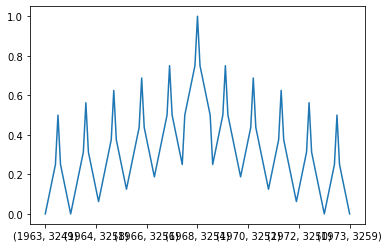

In [ ]:
reward.stack().plot()